## Scanpy: trajectory analysis (PAGA)
元URL: https://scanpy-tutorials.readthedocs.io/en/latest/paga-paul15.html

Scanpyを用いた軌道解析です。軌道解析法には partition-based graph abstraction (PAGA; Wolf et al, 2019) を採用しています。PAGAは細胞数が多く軌道が複雑であるようなサンプルに対して有効であるとされています。

以下の作業は Google Colab 上で行います。

In [92]:
# scanpyインストール
!pip install seaborn scikit-learn statsmodels numba python-igraph louvain scanpy # pytables 

In [94]:
# ライブラリ読み込み
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
results_file = './write/paul15.h5ad'

sc.settings.set_figure_params(dpi=80, frameon=False)  # low dpi (dots per inch) yields small inline figures

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.10 numpy==1.16.5 scipy==1.3.1 pandas==0.24.2 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1


### データ読み込み
ここではscanpyライブラリ内で提供されている paul15 データ (Hematopoiesis from self-renewing stem cells) を用います。
細胞アノテーションつきの 2,730 細胞データです。


In [108]:
adata = sc.datasets.paul15()
adata

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


AnnData object with n_obs × n_vars = 2730 × 3451 
    obs: 'paul15_clusters'
    uns: 'iroot'

### 正規化、次元削減、クラスタリング

In [109]:
# 正規化、HVGの抽出
sc.pp.recipe_zheng17(adata)

running recipe zheng17
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts_all', counts per cell before normalization (adata.obs)
extracting highly variable genes
    finished (0:00:00)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
    finished (0:00:00)


In [110]:
# PCAの計算
sc.tl.pca(adata, svd_solver='arpack')

computing PCA with n_comps = 50
    finished (0:00:00)


In [111]:
# 第20主成分までを用いてグラフクラスタリング
sc.pp.neighbors(adata, n_neighbors=4, n_pcs=20)
sc.tl.draw_graph(adata)

computing neighbors
    using 'X_pca' with n_pcs = 20
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:16)


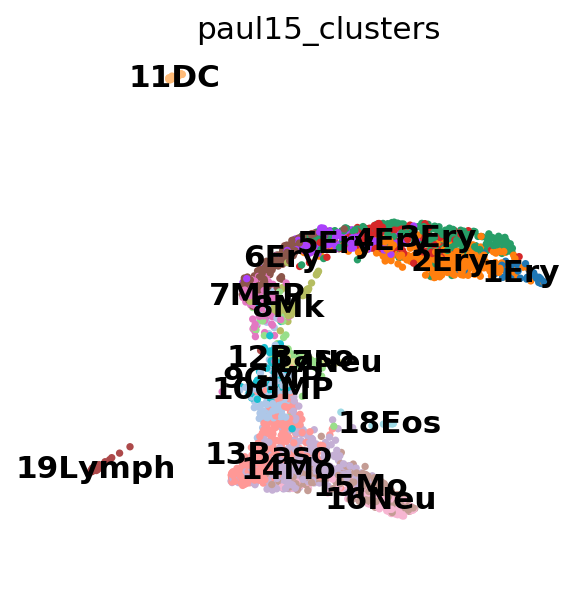

In [112]:
# 可視化
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

### Optional: diffusion mapによる可視化

分化細胞を可視化する場合、diffusion mapを用いた方が綺麗にプロットできる場合があります。以下ではdiffusion mapによる可視化を実行しています。



In [113]:
sc.tl.diffmap(adata)
sc.pp.neighbors(adata, n_neighbors=10, use_rep='X_diffmap')

computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         1.         0.9989277  0.99671    0.99430376 0.9893979
     0.9883686  0.98731065 0.9839869  0.983007   0.9790809  0.97625583
     0.97443694 0.9729161  0.9652972 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing neighbors
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)


In [114]:
sc.tl.draw_graph(adata)

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:14)


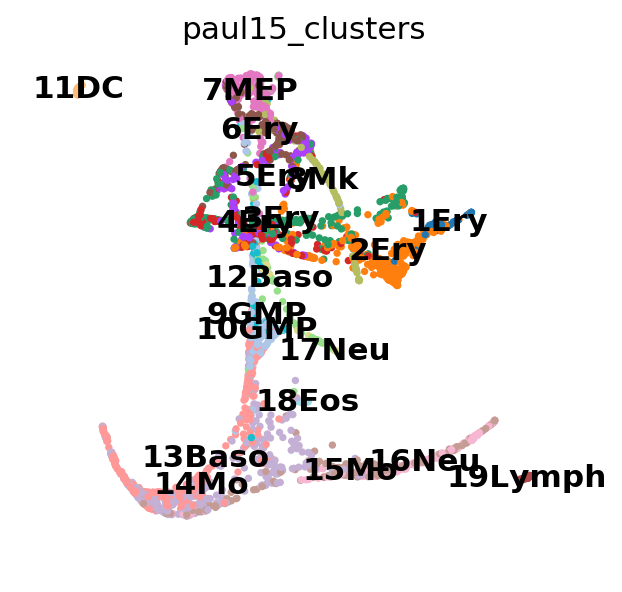

In [115]:
sc.pl.draw_graph(adata, color='paul15_clusters', legend_loc='on data')

### PAGAの実行
PAGAは得られたクラスタを一つのノードとみなし、ノードごとの関係性を可視化することにより、大規模かつ複雑なグラフの「粗視化」ネットワークを推定します。

In [116]:
# クラスタリング
sc.tl.louvain(adata, resolution=1.0)

running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 25 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:00)


In [117]:
# PAGA実行
sc.tl.paga(adata, groups='louvain')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)


### クラスタのアノテーション
以下の既知のマーカを元に各クラスタをアノテートします。

|cell type|	marker|
|---|---|
|HSCs|	Procr|
|Erythroids|	Gata1, Klf1, Epor, Gypa, Hba-a2, Hba-a1, Spi1|
|Neutrophils|	Elane, Cebpe, Ctsg, Mpo, Gfi1|
|Monocytes|	Irf8, Csf1r, Ctsg, Mpo|
|Megakaryocytes|	Itga2b (encodes protein CD41), Pbx1, Sdpr, Vwf|
|Basophils|	Mcpt8, Prss34|
|B cells|	Cd19, Vpreb2, Cd79a|
|Mast cells|	Cma1, Gzmb, CD117/C-Kit|
|Mast cells & Basophils	|Ms4a2, Fcer1a, Cpa3, CD203c (human)|

/usr/local/lib/python3.6/dist-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/usr/local/lib/python3.6/dist-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or acces

--> added 'pos', the PAGA positions (adata.uns['paga'])


/usr/local/lib/python3.6/dist-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


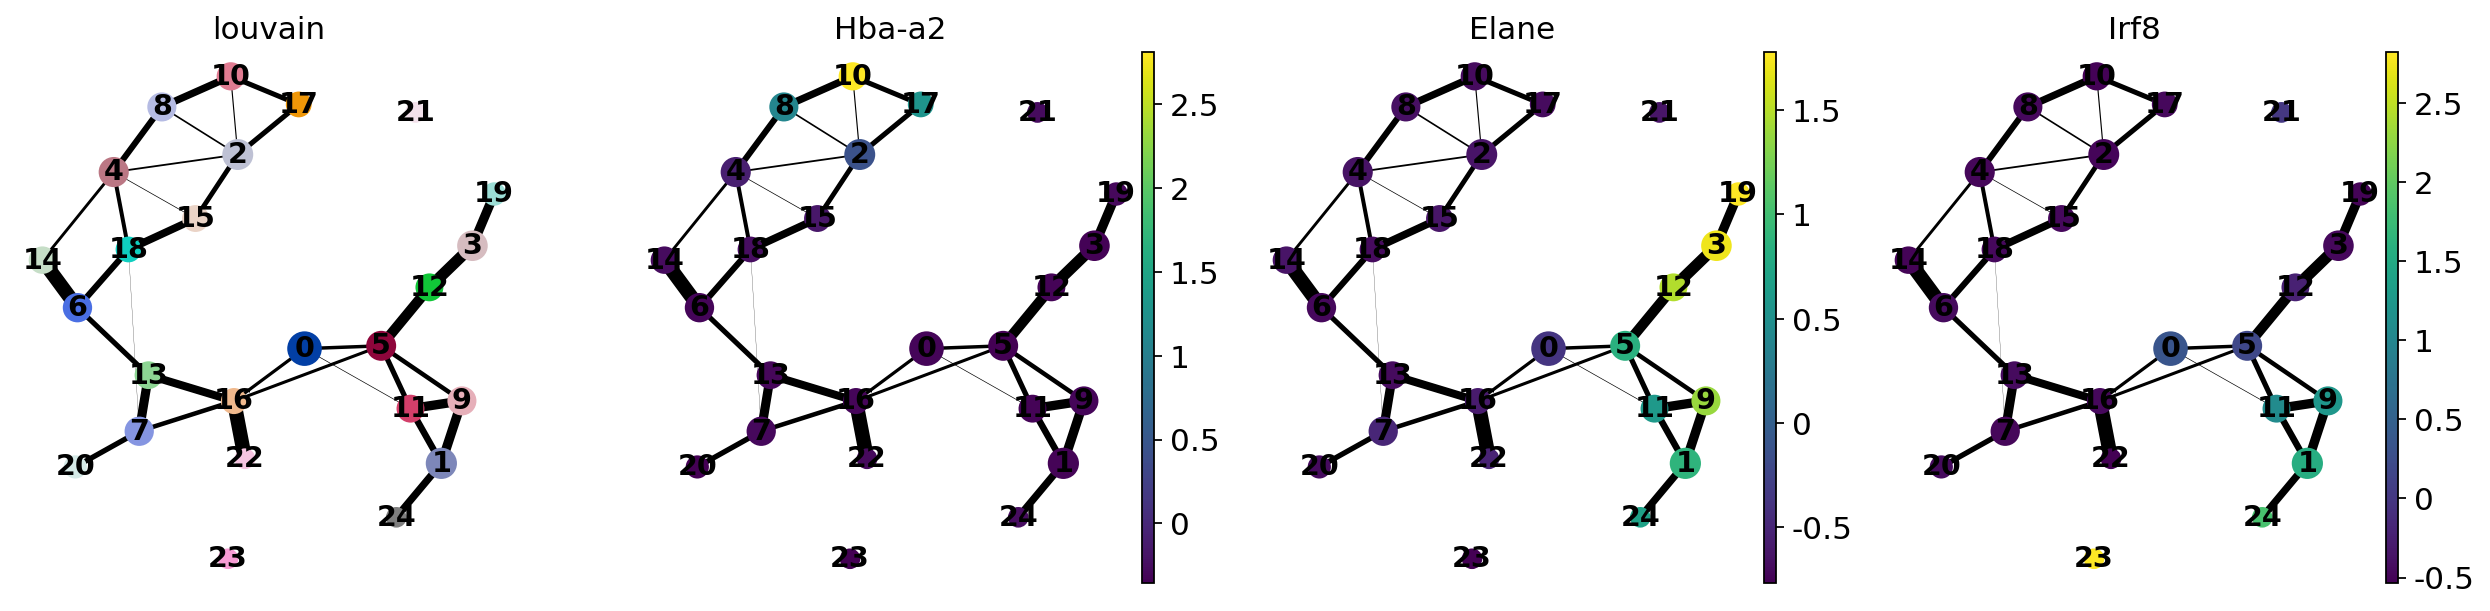

In [118]:
sc.pl.paga(adata, color=['louvain', 'Hba-a2', 'Elane', 'Irf8'])

/usr/local/lib/python3.6/dist-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/usr/local/lib/python3.6/dist-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or acces

--> added 'pos', the PAGA positions (adata.uns['paga'])


/usr/local/lib/python3.6/dist-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


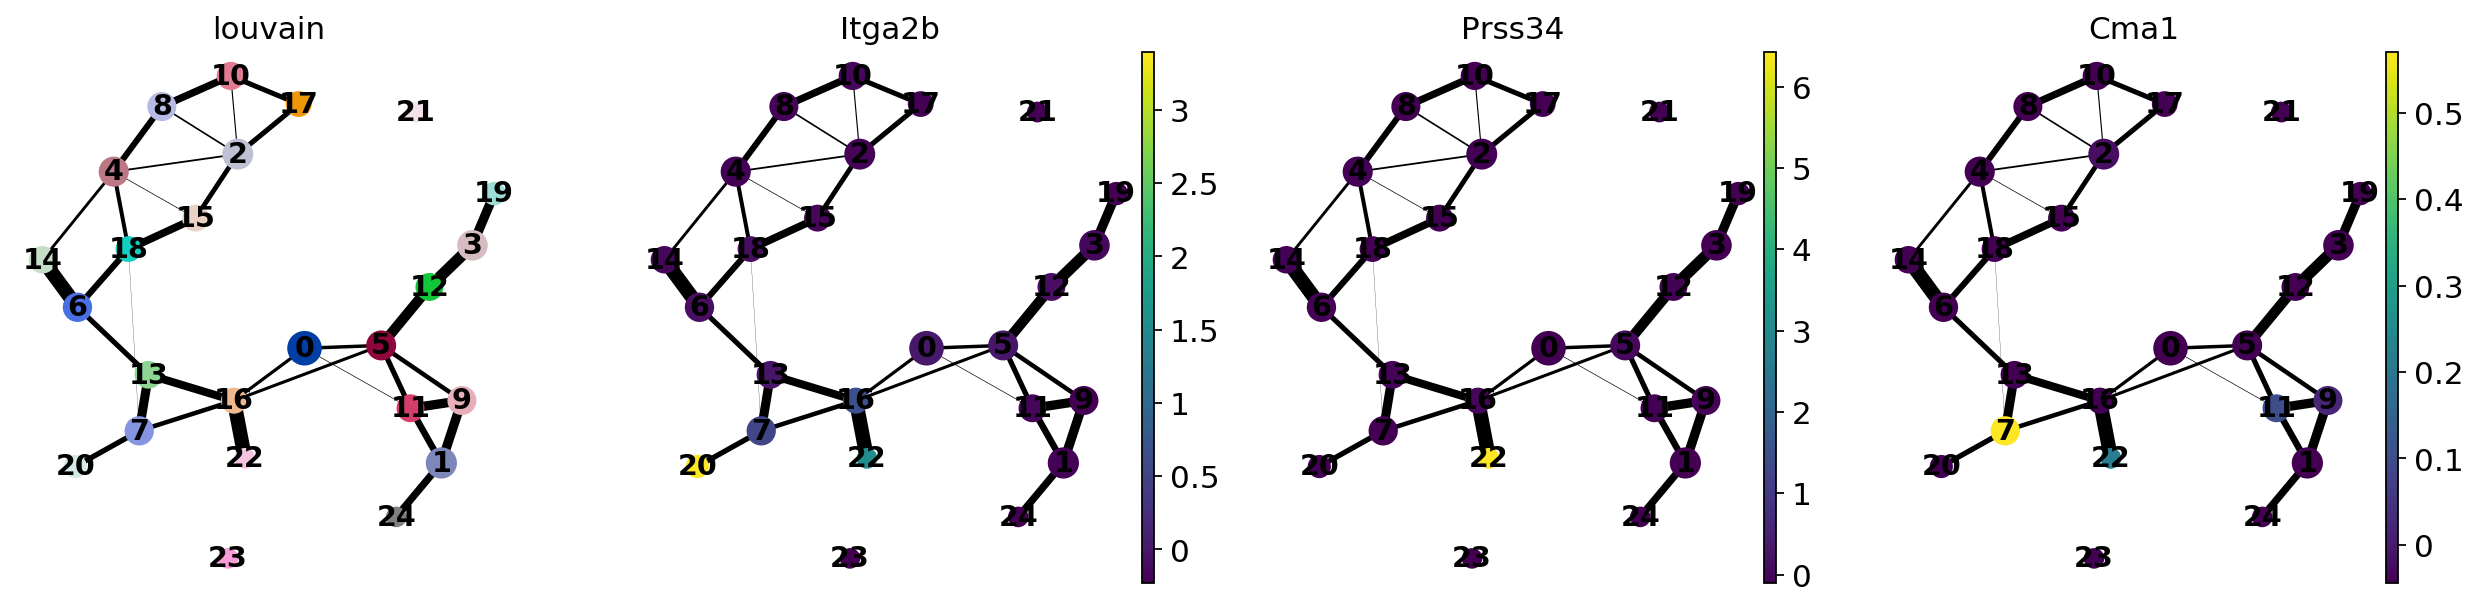

In [119]:
sc.pl.paga(adata, color=['louvain', 'Itga2b', 'Prss34', 'Cma1'])

In [121]:
adata.obs['louvain'].cat.categories

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24'],
      dtype='object')

In [0]:
# アノテーションをもとにクラスタのラベルを修正
adata.obs['louvain_anno'] = adata.obs['louvain']
adata.obs['louvain_anno'].cat.categories = ['0', '1', '2', '3', '4', '5', '6', '7', 
                                            '8', '9', '10/Ery', '11', '12','13', '14', '15', 
                                            '16/Stem', '17', '18', '19/Neu', '20/Mk', '21', '22/Baso', '23', '24/Mo']

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])


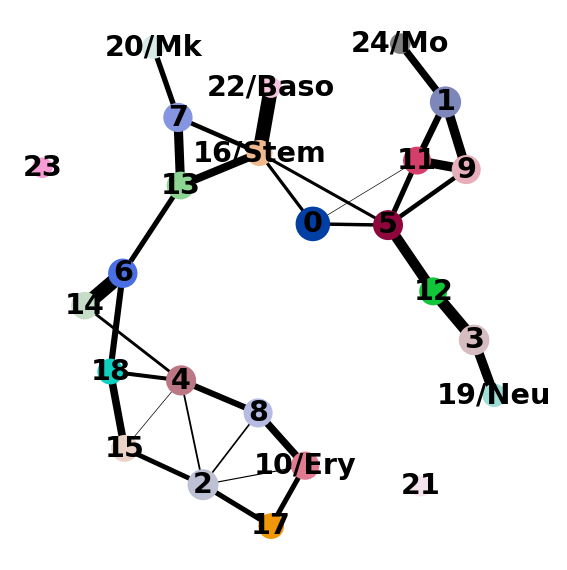

In [124]:
sc.tl.paga(adata, groups='louvain_anno')
sc.pl.paga(adata, threshold=0.03)

### 細胞レベルでの2次元プロット
PAGAで得られたクラスタレベルのネットワーク情報をもとに、細胞レベルでの2次元マップを再構築します。

In [125]:
sc.tl.draw_graph(adata, init_pos='paga')

drawing single-cell graph using layout 'fa'
    finished: added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm) (0:00:14)


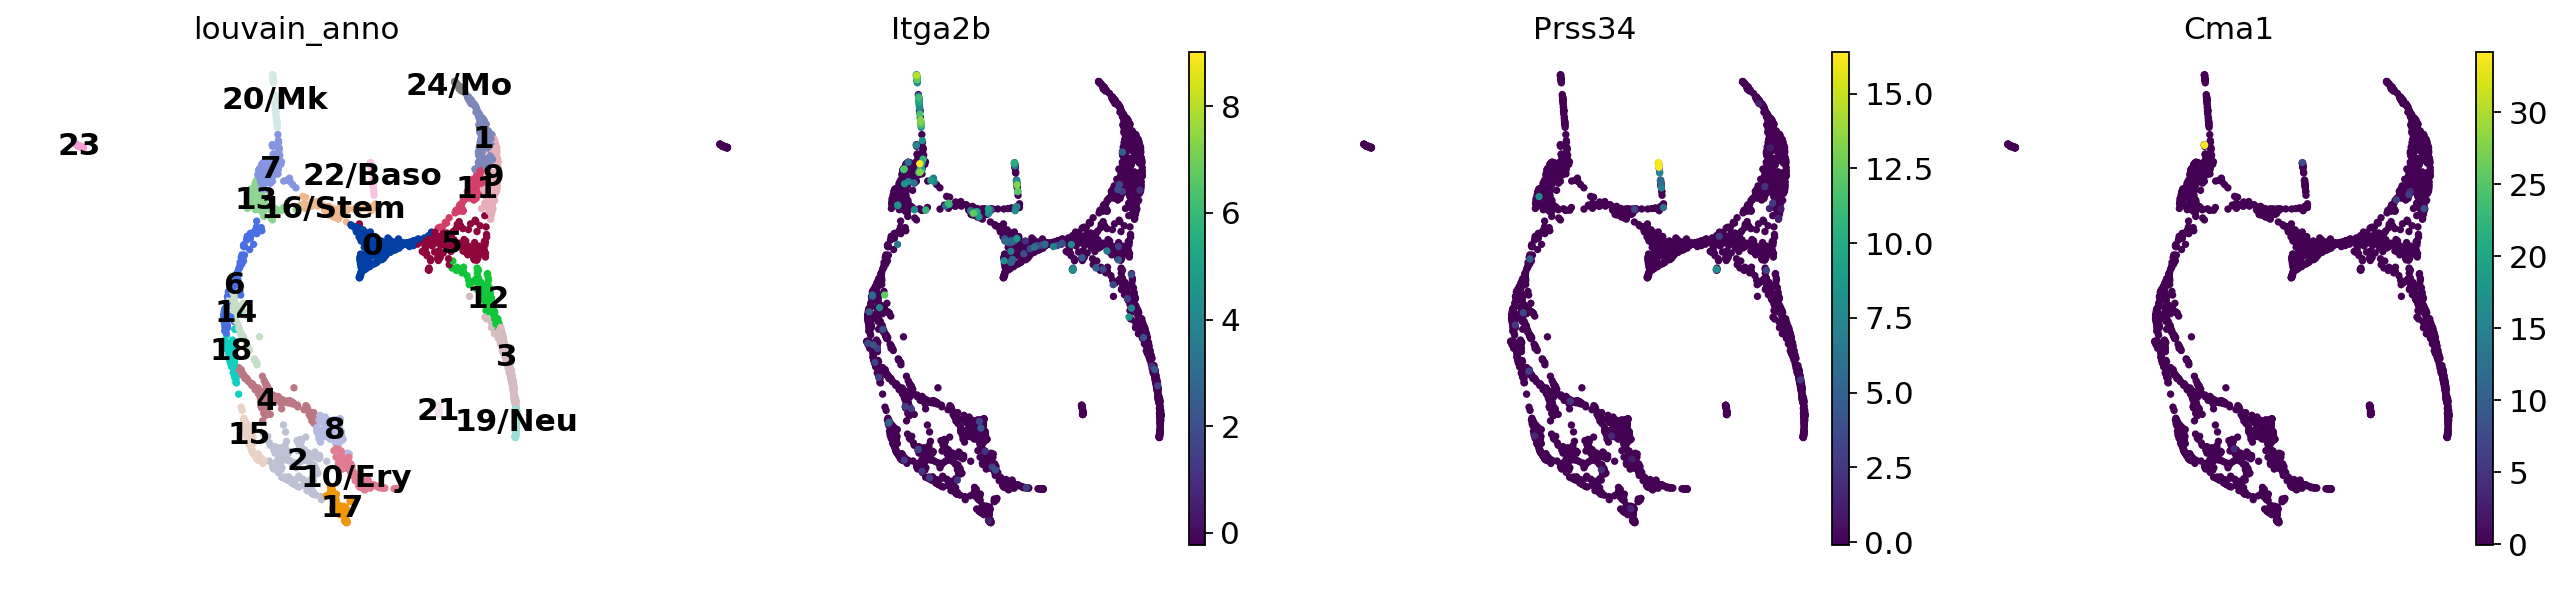

In [126]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'Itga2b', 'Prss34', 'Cma1'], legend_loc='on data')

#### 色の変更
色が見づらいのでもう少し綺麗なカラーマップに変更します。

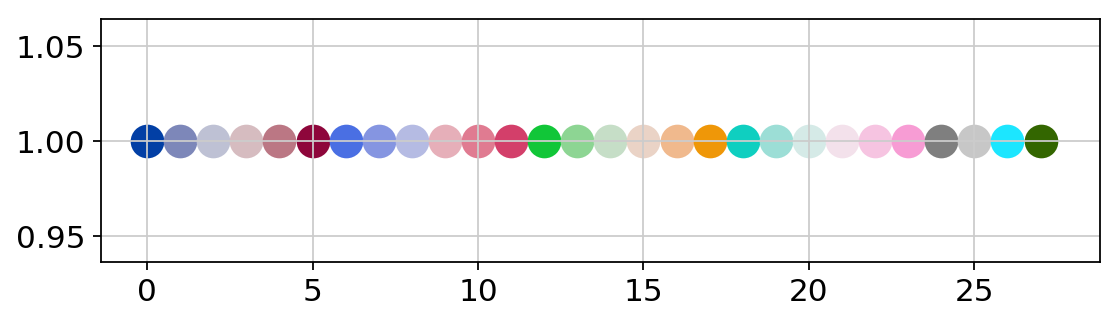

In [127]:
# Choose the colors of the clusters a bit more consistently.
pl.figure(figsize=(8, 2))
for i in range(28):
    pl.scatter(i, 1, c=sc.pl.palettes.zeileis_26[i], s=200)
pl.show()

In [0]:
zeileis_colors = np.array(sc.pl.palettes.zeileis_26)
new_colors = np.array(adata.uns['louvain_anno_colors'])

new_colors[[16]] = zeileis_colors[[12]]  # Stem colors / green
new_colors[[10, 17, 5, 3, 15, 6, 18, 13, 7, 12]] = zeileis_colors[[5, 5, 5, 5, 11, 11, 10, 9, 21, 21]]  # Ery colors / red
new_colors[[20, 8]] = zeileis_colors[[17, 16]]  # Mk early Ery colors / yellow
new_colors[[4, 0]] = zeileis_colors[[2, 8]]  # lymph progenitors / grey
new_colors[[22]] = zeileis_colors[[18]]  # Baso / turquoise
new_colors[[19, 14, 2]] = zeileis_colors[[6, 6, 6]]  # Neu / light blue
new_colors[[24, 9, 1, 11]] = zeileis_colors[[0, 0, 0, 0]]  # Mo / dark blue
new_colors[[21, 23]] = zeileis_colors[[25, 25]]  # outliers / grey

adata.uns['louvain_anno_colors'] = new_colors

--> added 'pos', the PAGA positions (adata.uns['paga'])


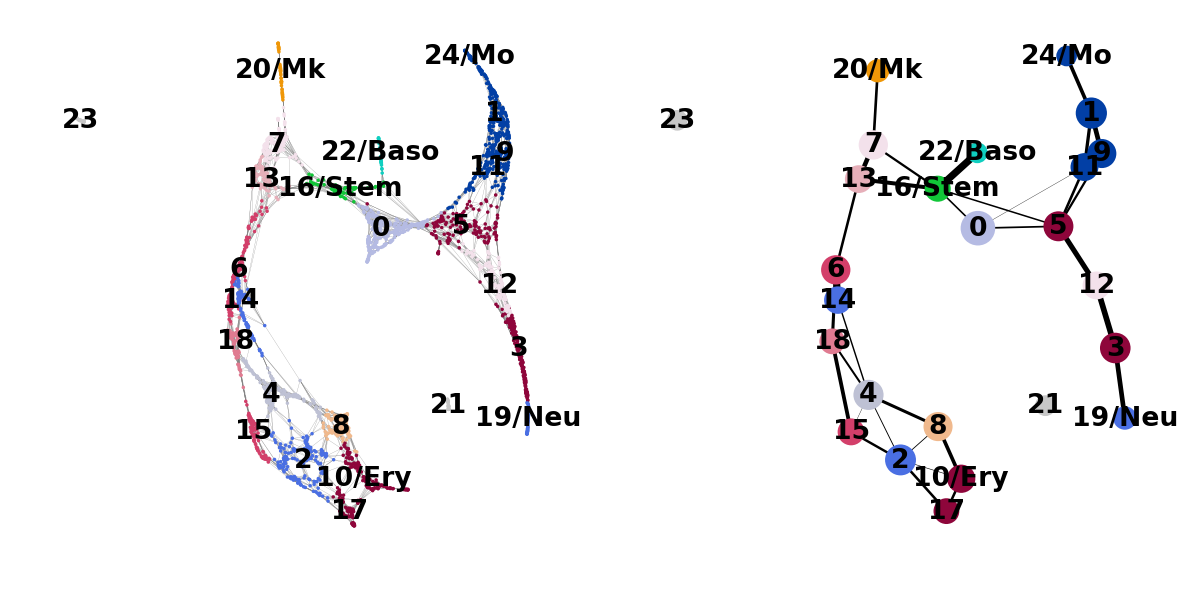

In [130]:
# 細胞レベルとクラスタレベルでの可視化
sc.pl.paga_compare(
    adata, threshold=0.03, title='', right_margin=0.2, size=10, edge_width_scale=0.5,
    legend_fontsize=12, fontsize=12, frameon=False, edges=True, save=True)

PAGAの軌道に沿った遺伝子発現の変化を可視化

In [0]:
# どのクラスタをrootにするかを選ぶ。ここでは16/Stemを選択
adata.uns['iroot'] = np.flatnonzero(adata.obs['louvain_anno']  == '16/Stem')[0]

In [132]:
sc.tl.dpt(adata)

computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)


In [0]:
# 軌道解析のためのマーカ遺伝子を指定
gene_names = ['Gata2', 'Gata1', 'Klf1', 'Epor', 'Hba-a2',  # erythroid
              'Elane', 'Cebpe', 'Gfi1',                    # neutrophil
              'Irf8', 'Csf1r', 'Ctsg']                     # monocyte

In [134]:
# データを生成しなおし（adata.raw に格納）
adata_raw = sc.datasets.paul15()
sc.pp.log1p(adata_raw)
sc.pp.scale(adata_raw)
adata.raw = adata_raw

... storing 'paul15_clusters' as categorical
Trying to set attribute `.uns` of view, making a copy.


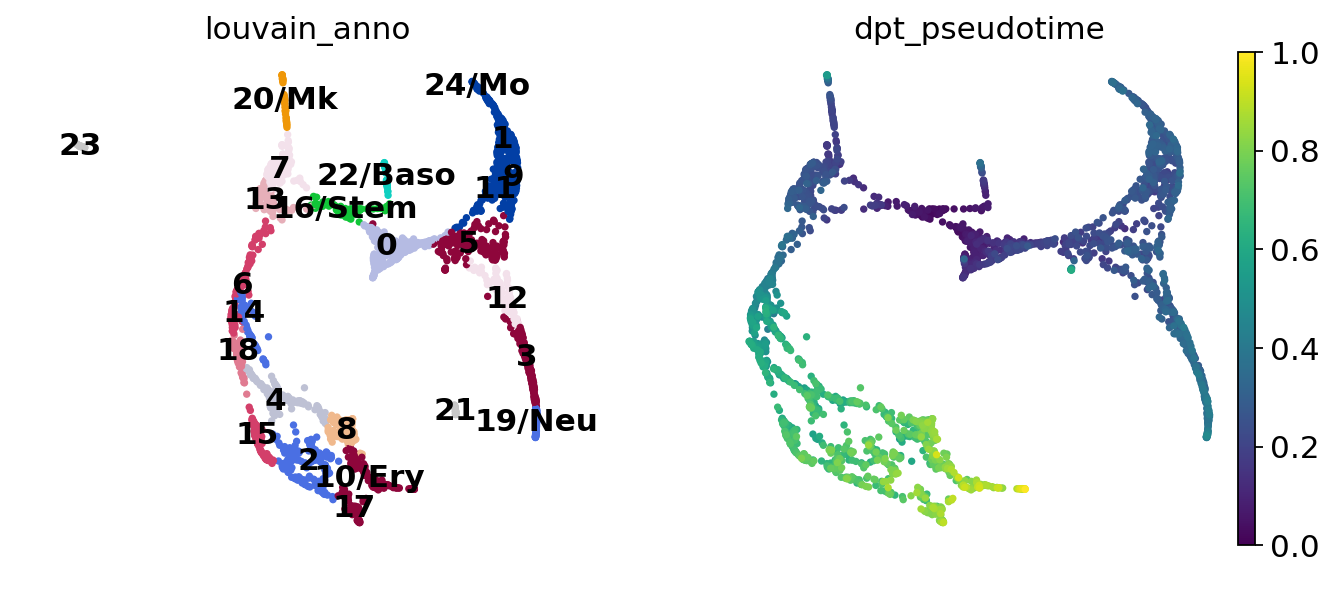

In [135]:
sc.pl.draw_graph(adata, color=['louvain_anno', 'dpt_pseudotime'], legend_loc='on data')

In [0]:
# パスの定義
paths = [('erythrocytes', [16, 12, 7, 13, 18, 6, 5, 10]),
         ('neutrophils', [16, 0, 4, 2, 14, 19]),
         ('monocytes', [16, 0, 4, 11, 1, 9, 24])]

In [0]:
adata.obs['distance'] = adata.obs['dpt_pseudotime']
adata.obs['clusters'] = adata.obs['louvain_anno']  # just a cosmetic change
adata.uns['clusters_colors'] = adata.uns['louvain_anno_colors']

In [0]:
!mkdir -p write

#### 遺伝子の可視化

/usr/local/lib/python3.6/dist-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()
/usr/local/lib/python3.6/dist-packages/anndata/core/anndata.py:299: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or acces

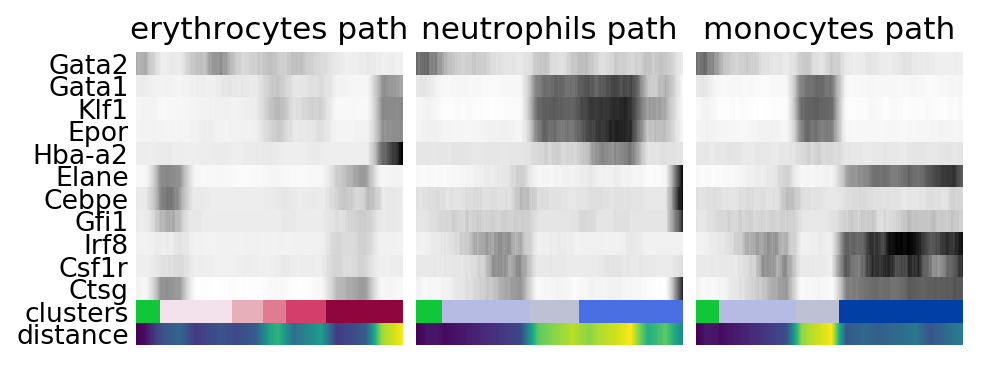

In [139]:
_, axs = pl.subplots(ncols=3, figsize=(6, 2.5), gridspec_kw={'wspace': 0.05, 'left': 0.12})
pl.subplots_adjust(left=0.05, right=0.98, top=0.82, bottom=0.2)
for ipath, (descr, path) in enumerate(paths):
    _, data = sc.pl.paga_path(
        adata, path, gene_names,
        show_node_names=False,
        ax=axs[ipath],
        ytick_fontsize=12,
        left_margin=0.15,
        n_avg=50,
        annotations=['distance'],
        show_yticks=True if ipath==0 else False,
        show_colorbar=False,
        color_map='Greys',
        groups_key='clusters',
        color_maps_annotations={'distance': 'viridis'},
        title='{} path'.format(descr),
        return_data=True,
        show=False)
    data.to_csv('./write/paga_path_{}.csv'.format(descr))
pl.savefig('./figures/paga_path_paul15.pdf')
pl.show()